# Learning mass distributions in asteroids

In this tutorial we will show how we can use heyoka.py's support for the [variational equations](./var_ode_sys.ipynb) to solve [inverse problems](https://en.wikipedia.org/wiki/Inverse_problem). Specifically, our goal will be to determine the mass distribution in an asteroid from the observed trajectory of a spacecraft orbiting the asteroid. The asteroid will be represented with a [mascon model](https://hgss.copernicus.org/articles/13/205/2022/), that is, as a set of massive point particles each one generating a Newtonian gravitational field.

The main objective of the tutorial is to show how heyoka.py can interact with solvers and optimisers from the scientific Python ecosystem, and, in particular, how we can use the partial derivatives computed via the variational equations in order to reduce the time-to-solution. Thus, the problem setup is very simplified and idealised: the asteroid will be fixed in an inertial reference frame, gravity is the only force acting on the spacecraft, and no errors, uncertainty or noise are assumed in the observed orbit. Throughout the example, we will be using adimensional units (that is, the total mass of the asteroid is 1 and the gravitational constant is also 1).

## Learning mascon positions

We will be considering a simple mascon model consisting of 10 particles. We will randomly-generate positions for the particles and accurately integrate the motion of a spacecraft around the asteroid for several orbits - this will be our "observed" trajectory. Let us begin by setting up a few parameters for our problem:

In [1]:
# Total number of mascons.
n_mascons = 10
# Number of sampling points for
# the observed trajectory.
n_sample_points = 1000
# Total integration time.
tfinal = 200.

Next, we generate random initial positions for the mascons within a cube centered in the origin:

In [2]:
import numpy as np

# Deterministic seeding.
rng = np.random.default_rng(42)
# Generate the mascon positions.
positions = rng.uniform(-.5, .5, (n_mascons, 3))
# All mascons have equal mass, total
# mass is 1.
masses = [1./n_mascons] * n_mascons

We then set up initial conditions for the spacecraft state that would correspond to a quasi-circular and quasi-equatorial Keplerian orbit if all the mascons were to be positioned in the origin:

In [3]:
# Initial state vector for the spacecraft (position + velocity).
orig_ics = np.array([1.5, 0.01, 0.02, 0.03, .81, 0.04])

We are now ready to generate our "observed" orbit. We will be using the {func}`~heyoka.model.fixed_centres()` function from the {ref}`model <api_model>` submodule to formulate the dynamical equations for a set of fixed massive particles:

In [4]:
import heyoka as hy

# Formulate the dynamical equations.
dyn = hy.model.fixed_centres(masses=masses, positions=positions)

# Create a numerical integrator.
ta = hy.taylor_adaptive(dyn, orig_ics)

# Construct a time grid.
tgrid = np.linspace(0., tfinal, n_sample_points)

# Numerically integrate the state of the system
# at the grid point.
obs_orbit = ta.propagate_grid(tgrid)[-1]

Let us take a look at the orbit:

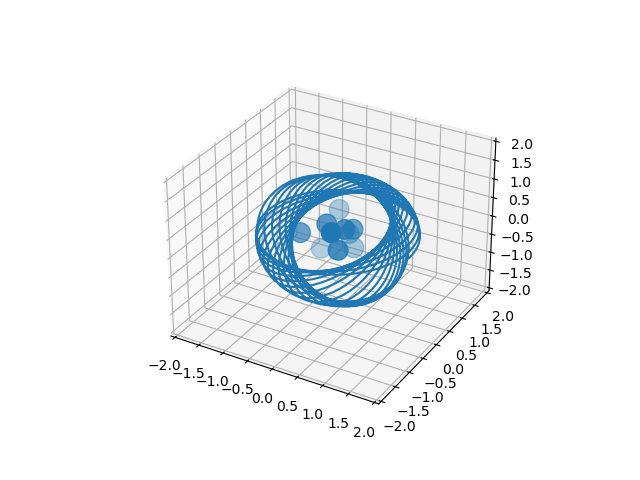

In [5]:
%matplotlib widget

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

# Plot the mascons.
ax.scatter(positions[:,0], positions[:,1], positions[:,2], s=400.)

# Plot the observed orbit.
ax.plot(obs_orbit[:,0], obs_orbit[:,1], obs_orbit[:,2]);

So far, so good!

Now, we will be pretending that precise knowledge of the position of the mascons has been lost in a catastrophic accident, and that we need to reconstruct the mascons positions from a rough initial guess and the observed trajectory.

In order to do so, we will be setting up a [nonlinear least square](https://en.wikipedia.org/wiki/Non-linear_least_squares) analysis in which we will seek to minimise the difference between the observed trajectory of the spacecraft and a numerically-integrated trajectory with parametrised mascon positions. The solver will iteratively adjust the values of the mascon positions to minimise the difference between the observed and computed trajectory, using the derivatives provided by the [variational equations](./var_ode_sys.ipynb) to speed up and improve the convergence properties of the process.

Let us begin by re-formulating the dynamics of the system with parametrised positions (instead of using specific numerical values for the positions, as we did previously to generate the observed orbit):

In [6]:
# Parametrised mascon positions.
par_pos = np.array([hy.par[_] for _ in range(3*n_mascons)]).reshape((n_mascons,3))

# Parametrised dynamics.
par_dyn = hy.model.fixed_centres(masses=masses, positions=par_pos)

Next, we set up a variational integrator, requesting the first-order partial derivatives of the state variables with respect to all parameters:

In [7]:
# The variational integrator.
ta_var = hy.taylor_adaptive(hy.var_ode_sys(par_dyn, hy.var_args.params),
                            orig_ics, compact_mode=True)

We also need to set up a non-variational integrator. The reason for this is that the solver that we will be using computes the residuals and the Jacobian in separate stages. Thus, we will be using the variational integrator for the computation of the Jacobian and the non-variational one for the computation of the residuals. If we used instead a solver that computes residuals and Jacobian in a single function call, we could avoid the use of the non-variational integrator and just compute the residuals from the output of the variational one.

In [8]:
# The non-variational integrator.
ta = hy.taylor_adaptive(par_dyn, orig_ics, compact_mode=True)

We also store a separate copy of the initial conditions of the variational integrator for later use:

In [9]:
from copy import copy
orig_var_ics = copy(ta_var.state)

And we fetch index range of the derivatives in the state vector of the variational integrator. This will be used to compute the Jacobian during the solver iterations:

In [10]:
# Get the range of first-order derivatives in ta_var.state.
sl = ta_var.get_vslice(order=1)

We are now ready to formulate the objective function (i.e., the function for the computation of the residuals). We will be using the {func}`scipy.optimize.least_squares()` solver, and thus we need to ensure that the residuals are returned in the correct format. Specifically, we will be returning an array of ``6*n_sample_points`` residuals, with each residual being computed as the difference between an observed position/velocity component and the computed one. The input to this function is a 1D array containing the current candidate guess for the mascon positions:

In [11]:
def objfun(x):
    # Reset the state of the non-variational
    # integrator.
    ta.time = 0.
    ta.state[:] = orig_ics

    # Assign the mascon positions from x
    ta.pars[:] = x

    # Propagate over the time grid.
    orb = ta.propagate_grid(tgrid)[-1]

    # Compute and return the residuals
    # in the format expected by least_squares()
    # (i.e., as a flat 1D vector).
    return (orb - obs_orbit).flatten()

The function for the computation of the Jacobian is similar: we will be returning a 2D array of shape ``(6*n_sample_points, 3*n_mascons)``, where each row contains the derivatives of a residual with respect to the mascon positions. Note that because each residual is defined as a simple difference of the computed quantity with respect to the observed one (a constant), the derivatives of the residuals can be read directly from the values of the variational variables without further computations:

In [12]:
def jacobian(x):
    # Reset the state of the variational
    # integrator.
    ta_var.time = 0.
    ta_var.state[:] = orig_var_ics

    # Assign the mascon positions from x.
    ta_var.pars[:] = x

    # Propagate over the time grid.
    orb_var = ta_var.propagate_grid(tgrid)[-1]

    # Return the Jacobian. We can directly
    # read the values of the derivatives as computed
    # by the variational equations.
    return orb_var[:,sl].reshape(6*n_sample_points, 3*n_mascons)

Finally, we are ready to run the least squares analysis via {func}`scipy.optimize.least_squares()`. As an initial guess for the mascon positions, we take the known (correct) positions and fudge them by ~10%. We also set as bounds for the optimisation an origin-centred cube.

In [13]:
from scipy.optimize import least_squares

# Formulate a random initial guess around the known solution.
initial_guess = (positions + rng.uniform(-1e-2, 1e-2, positions.shape)).flatten()

# Run the least squares analysis.
opt_res = least_squares(objfun, initial_guess,
                        jac=jacobian,
                        bounds=([-1.]*n_mascons*3, [1.]*n_mascons*3))
opt_res

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 0.000e+00  0.000e+00 ... -5.035e-14 -6.917e-14]
           x: [ 2.740e-01 -6.112e-02 ... -3.457e-01  1.830e-01]
        cost: 1.1999479709156084e-22
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               ...
               [ 3.249e+00  1.351e-01 ... -1.562e+00  1.802e-01]
               [ 3.646e+00  1.048e-02 ... -3.385e-01  7.886e-01]]
        grad: [-1.383e-08 -6.847e-10 ...  2.027e-09 -5.067e-10]
  optimality: 1.1111748078102507e-08
 active_mask: [0 0 ... 0 0]
        nfev: 37
        njev: 32

We can see that indeed the analysis terminated successfully. How faithfully did we reconstruct the original positions of the mascons?

In [14]:
opt_res.x - positions.flatten()

array([-4.38593606e-13, -4.67736960e-13, -3.07309733e-13, -3.24740235e-13,
        8.58202398e-14,  8.59312621e-14, -1.93844940e-13, -7.22200078e-14,
        4.02455846e-14,  3.94975719e-13,  3.59684504e-13, -2.78610468e-13,
        5.39346345e-13,  9.29256672e-14, -1.98722983e-13,  1.40998324e-14,
       -1.95607419e-14, -7.43849426e-15,  8.64863736e-14, -1.40165657e-13,
        6.07236483e-13, -6.34492459e-14,  4.27435864e-14, -1.06248343e-13,
        2.98094882e-14,  6.94444502e-14,  1.53453639e-13, -3.34177130e-14,
        5.46229728e-14,  2.24820162e-14])

Pretty good!